# **Basic Computer Lane Finding** 

16-DEC-2020

## Goals

- Create an image processing pipeline that detects road lanes 
- Discover challenges in lane-finding
- Discover image-preprocessing techniques
- Apply Canny Edge detection and Hough transforms
- Discover limitations and additional improvements 
- Fulfill a requirement of the Udacity Self-Driving Car Engineer Nanodegree Program

## The Pipeline

Teaching a computer to find lanes is not a trivial task. Basic lane detection involved continuously transforming an image of a freeway to allow a lines to be computed and to be lane lines extrapolated and superimposed on that image. For this project, the final pipeline of transforming this image of a freeway is composed of:
- Finding areas of yellow and white colors 
- Tracing edges
- Masking out unneeded areas
- Creating lines based on edges detected
- Reducing lines to two left and right lanes
- Superimposing the lanes on initial image to create the final

## Challenges

Initially, efforts started with:
- Transforming to grayscale 
- Blurring the image to reduce image noise
- Tracing edges
- Masking out unneeded areas
- Creating lines based on edges detected
- Superimposing the lines on initial image to create the final

The initial efforts in applying edge detection and Hough transformation techniques led to two major challenges:
- Reducing multiple lines detected into to reasonable lane lines
- Detecting lanes in low contrast and shadow

### Finding Just 2 Lines out of a Gazillion

Of course, the resulting image had way too many lines. In order to draw just two lines to represent the left and right lanes, the function draw_lines () the following was needed:

* Sort lines into those on the left, and those on the right side of the screen. Generally, lines with negative slopes were considered to be lines on the left side of the screen and those with positive slopes are on the right side. Also, exclude any steep or shallow lines which we assume are outliers:

```
def sort_line_params(lines, min_d=10):
    ...
    for line in lines:
        for (x1, y1, x2, y2) in line:
	        if (abs(x2 - x1) > min_d) and (abs(y2 - y1) > min_d):
	             slope = (y2 - y1) / (x2 - x1)
	             yint = y1 - slope * x1
	             if slope < 0:
	                 left_slopes.append(slope)
	                 left_yints.append(yint)
	             else:
	                 right_slopes.append(slope)
	                 right_yints.append(yint) 
	...	   
```
* Calculate the average slope and y-intercept of the lines that of the left lines and those of the right lines:
```
	...
    left_params  = (np.average(left_slopes), np.average(left_yints))
    right_params = (np.average(right_slopes), np.average(right_yints))
    ...
 ```
* Use the average slopes of the left and right groups can then be used to calculate the lines that represent left and right lanes respectively.

This approach led to a detection of reasonable lane lines when the pipeline processed `solidWhiteRight.mp4` and `solidYellowLeft.mp4`. However, it failed to detect lanes in an area of low contrast and shadow in `challenge.mp4`.

### Saturation and Contrast Tests to Improve Lane Detection in Low Contrast and Shade

Increasing saturation and artificially applying extreme contrast was tested to verify if lane detection on lighter-colored concrete (low contrast) and in shadow improved. The following image processing was applied to achieve this:
- RGB image was converted to an HSV image. 
- The S value of the image was increased to a maximum of 255 for all pixels
- The image converted to grayscale. 
- An extreme amount of contrast was then applied  by setting all pixels below a grayscale value of 50 were  to 0, and the rest to 255.

```
def test_saturate (image):

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:,:,1] = 255  
    image_saturated = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return image_saturated 
```

![image-saturated.png](test_images_output/image-saturated.png "Image after applying high saturation")

```
def test_max_contrast (image_gray, lo=50):
    
    image_max_contrast = np.zeros_like(image_gray)
    
    f = image_gray < lo
    image_max_contrast = np.where (f, 0, 255)
                
    return  np.array(image_max_contrast, dtype=np.uint8)
```

![image-max_contrast.png](test_images_output/image-max_contrast.png "Image after transforming to gray scale and max contrast to a saturated image")

While lane detection improved slightly for `challenge.mp4`, the pipeline failed to  detect the lanes in shadow.

###  Masking Yellow and White

Testing shifted to detecting areas that are yellow or white. Those areas would then be marked with a mask which could be used for further processing in the pipeline. Through trial and error, the following HSV ranges were set for yellow and white:
```
test_yellow_range = [np.array([20,  70,   0]), 
                np.array([40, 255, 255])]

test_white_range  = [np.array([  0,  0, 180]), 
                np.array([179, 25, 255])]
```
These ranges could then be used in `opencv.inRange()` to create a mask for each color, then combined to create a complete mask highlighting the yellow + white areas, thus marking yellow and white lanes.
```
def test_highlight_yellow_and_white (image):
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    mask_yellow = cv2.inRange(hsv_image, test_yellow_range[0], test_yellow_range[1])
    mask_white  = cv2.inRange(hsv_image, test_white_range[0], test_white_range[1])
    
    #--- combine mask of yellow and white areas into one mask
    mask = mask_yellow + mask_white
                      
    return mask
```

![Before and after marking yellow and white areas](test_images_output/image_yw_mask.png "Before and after marking yellow and white areas")

By marking yellow and white areas the pipeline now had successfully detected lanes in low contrast and shaded areas in `challenge.mp4`. 


![challenge_light_concrete.jpg](test_videos_output/challenge_light_concrete.jpg "Pipeline detecting lane in light concrete")


## Other Notes
### Images at each Pipeline Stage

Because the image processed by the function `test_highlight_yellow_and_white()` produced a mask that was already gray scale and not noisy, the pipeline skipped applying a gaussian blur and proceeded with edge detection, Hough transformation, and superimposing the lanes on the final image. Results of applying this shorter pipeline are below:

![laned_solidWhiteCurve.jpg](test_images_output/laned_solidWhiteCurve.jpg "laned_solidWhiteCurve.jpg ")
![laned_solidWhiteRight.jpg](test_images_output/laned_solidWhiteRight.jpg "laned_solidWhiteRight.jpg")
![laned_solidYellowCurve.jpg](test_images_output/laned_solidYellowCurve.jpg "laned_solidYellowCurve.jpg")
![laned_solidYellowCurve2.jpg](test_images_output/laned_solidYellowCurve2.jpg "laned_solidYellowCurve2.jpg")
![laned_solidYellowLeft.jpg](test_images_output/laned_solidYellowLeft.jpg "laned_solidYellowLeft.jpg")
![laned_whiteCarLaneSwitch.jpg](test_images_output/laned_whiteCarLaneSwitch.jpg "laned_whiteCarLaneSwitch.jpg")

### Pipeline Limitations

- Lanes exhibit a lot of jitter,
- Lanes that are near-horizontal are not drawn
- Lanes that are near-vertical are not drawn
- Probably will not detect lanes at night or during inclement weather
- Faded lanes will probably not be detected 

### Areas of improvement
- Use theta (angle of incidence of line to horizontal) instead of slope
- Further tweaking parameters
- Including average of previous n-frames in calculating the lane line could help reduce lane jitter
- Collect metrics such as:
	- How many frames did not detect any lines
	- time to process each frame to understand pipeline performance
- Use CNN techniques to identify the lanes
- Draw continuous curve for curved lanes

> Written with [StackEdit](https://stackedit.io/).

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [2]:
 green = np.uint8([[[0,255,0 ]]])
 hsv_green = cv2.cvtColor(green,cv2.COLOR_BGR2HSV)
 hsv_green

array([[[ 60, 255, 255]]], dtype=uint8)

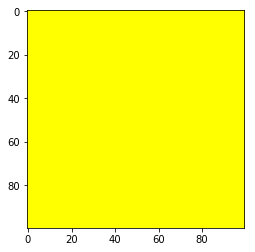

In [25]:

square = np.empty((100, 100, 3), dtype=np.uint8)
yellow = np.uint8([[[255, 255, 0]]])

square[:,:] = yellow

plt.imshow(square)



In [26]:
hsv_yellow = cv2.cvtColor(yellow,cv2.COLOR_RGB2HSV)
hsv_yellow

array([[[ 30, 255, 255]]], dtype=uint8)

In [27]:
hue = hsv_yellow[0][0][0]
hsv_yellow_range = [[hue - 10, 100, 100], [hue + 10, 255, 255]]
hsv_yellow_range 

[[20, 100, 100], [40, 255, 255]]

In [68]:
def hsv_color_range(rgb_color):
    
    hsv_color = cv2.cvtColor(rgb_color,cv2.COLOR_RGB2HSV)
    hue = hsv_color[0][0][0]
    
    lo_sv = 125
    hi_sv = 255
    hsv_color_range = np.uint8([[hue - 5, lo_sv, lo_sv], [hue + 5, hi_sv, hi_sv]])
    
    return hsv_color_range

r = hsv_color_range(yellow)
r[0], r[1]

(array([ 25, 125, 125], dtype=uint8), array([ 35, 255, 255], dtype=uint8))

In [70]:
r.shape

(2, 3)

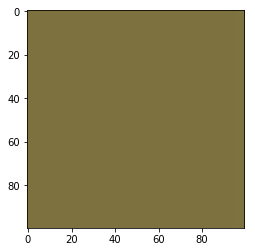

In [69]:
hsv_lo_square = np.empty((100, 100, 3), dtype=np.uint8)
hsv_lo_square[:, :] = r[0]
lo_square = cv2.cvtColor(hsv_lo_square, cv2.COLOR_HSV2RGB)

plt.imshow(lo_square)

In [5]:
import numpy as np
a = np.square ([2, 2, 2])
b = np.sum(a)
b

200 * 200

40000

In [79]:
a = np.array (
    [
        [
            [1, 2, 3], 
            [4, 5, 6], 
            [7, 8, 9]
        ],
        [
            [11, 12, 13], 
            [14, 15, 16], 
            [17, 18, 19]
        ],

    ])
a.shape

b = a + 2
b

# a[:, :, :] = np.array([202, 220, 230])
print (a, a.shape)

c = (a - b)
print("c",c)
# d = np.average(a, axis=2).reshape((d.shape, 1))
# d = np.average(a, axis=2)
# d = d[:,:,None]
d = np.square(c)
s = np.sum(d, axis=2)
print ("s", s)


f = d < 8

print("d",d)
print(d.shape)
e = np.where(d < 8, [0, 0, 0], [16, 16, 16])
e
print (f)
print (f.shape)

a[f] = [0, 0, 0]
print ("a[f]", a[f])
print (a)


[[[ 1  2  3]
  [ 4  5  6]
  [ 7  8  9]]

 [[11 12 13]
  [14 15 16]
  [17 18 19]]] (2, 3, 3)
c [[[-2 -2 -2]
  [-2 -2 -2]
  [-2 -2 -2]]

 [[-2 -2 -2]
  [-2 -2 -2]
  [-2 -2 -2]]]
s [[12 12 12]
 [12 12 12]]
d [[[4 4 4]
  [4 4 4]
  [4 4 4]]

 [[4 4 4]
  [4 4 4]
  [4 4 4]]]
(2, 3, 3)
[[[ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]]]
(2, 3, 3)


ValueError: NumPy boolean array indexing assignment cannot assign 3 input values to the 18 output values where the mask is true

In [4]:
import numpy as np
theta = np.arctan2([1])
theta

array([0.32175055, 0.78539816])

In [12]:
m = float('inf')

In [13]:
3 * m

inf